#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 학습을 위한 전처리 : 자연어 처리를 위한 전처리를 수행합니다.
        * 형태소 분석기를 활용하여 문장 어절들에 대해 형태소로 변환합니다.
    * 전처리 결과를 저장합니다.

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

In [2]:
pd.set_option('display.max_colwidth', None)  # None으로 설정하면 문자열이 잘리지 않고 전체가 출력됩니다.

In [3]:
# 시각화 한글폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumGothic')
sns.set(font="NanumGothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

# 경고 표시 무시
import warnings
warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
# 모든 행 출력
pd.set_option('display.max_rows', None)

# 모든 열 출력
pd.set_option('display.max_columns', None)

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 챗봇 데이터.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* Colab 환경에서 프로젝트 진행을 권장합니다.
    * 구글 드라이브에 project 폴더를 만들고 데이터 파일을 복사해 넣습니다.

* 구글 드라이브 연결

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/미니프로젝트6차part1/데이터'

### (3) 데이터 읽어오기

In [7]:
# 일상대화
common_df = pd.read_excel(f'{path}/일상대화.xlsx')

# 에이블스쿨 질문답변
faq_df = pd.read_excel(f'{path}/챗봇데이터.xlsx')

* 데이터 둘러보기

In [8]:
common_df.head()

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


In [9]:
common_df.shape

(506, 3)

In [10]:
common_df_intent = common_df['intent'].unique()

In [11]:
common_df_intent

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

* 일상 대화 데이터의 intent가 1부터 30까지가 있다.

* 저는 intent 1에서는 어떤 답변이 있고
* intent 2에서는 어떤 답변이 있고 ~~~~ intent 30에서는 어떤 답변이 있는지 궁금해졌습니다.

In [12]:
for cdi in common_df_intent:
    print(f'intent : {cdi}일 떄')
    print(common_df.loc[common_df['intent'] == cdi, '답변'])
    print()

intent : 1일 떄
0         as 맡기세요.
1         as 맡기세요.
2         as 맡기세요.
3     AS센터에 맡겨보세요.
4     AS센터에 맡겨보세요.
5     AS센터에 맡겨보세요.
6     AS센터에 맡겨보세요.
7     AS센터에 맡겨보세요.
8     AS센터에 맡겨보세요.
9     AS센터에 맡겨보세요.
10    AS센터에 맡겨보세요.
11    AS센터에 맡겨보세요.
12    AS센터에 맡겨보세요.
13    AS센터에 맡겨보세요.
14    AS센터에 맡겨보세요.
15    AS센터에 맡겨보세요.
Name: 답변, dtype: object

intent : 2일 떄
16     가장 중요한 거예요.
17     가장 중요한 거예요.
18    가장 중요한 목표네요.
19    가장 중요한 목표네요.
20    가장 중요한 목표네요.
21    가장 중요한 목표네요.
22    가장 중요한 목표네요.
23    가장 중요한 목표네요.
24    가장 중요한 목표네요.
25    가장 중요한 목표네요.
26    가장 중요한 목표네요.
27    가장 중요한 목표네요.
28    가장 중요한 목표네요.
29    가장 중요한 목표네요.
30    가장 중요한 목표네요.
31    가장 중요한 목표네요.
Name: 답변, dtype: object

intent : 3일 떄
32    감기 조심 하세요.
33    감기 조심 하세요.
34     감기 조심하세요!
35     감기 조심하세요!
36     감기 조심하세요.
37     감기 조심하세요.
38     감기 조심하세요.
39     감기 조심하세요.
40     감기 조심하세요.
41     감기 조심하세요.
42     감기 조심하세요.
43     감기 조심하세요.
44     감기 조심하세요.
45     감기 조심하세요.
46     감기 조심하세요.
47     감기 조심하세요.
48    감기 조심 하세요.
49    감기 조심

* 다음으로 에이블스쿨 FAQ 데이터를 봅시다.

In [13]:
faq_df.head()

,intent,Q,A
0,0,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,"KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다."
1,0,지원자격이 어떻게 되나요?,"KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다."
2,0,지원 조건이 궁금해요.,"KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다."
3,0,지원 자격에 대해서 알려주세요.,"KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다."
4,0,지원 자격 기준이 있나요?,"KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다."


In [14]:
faq_df.shape

(792, 3)

In [15]:
faq_df_intent = faq_df['intent'].unique()

* 에이블스쿨 FAQ 데이터의 intent가 0부터 22까지가 있다.

In [16]:
faq_df_intent

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

* 저는 intent 0에서는 어떤 답변이 있고
* intent 1에서는 어떤 답변이 있고 ~~~~ intent 22에서는 어떤 답변이 있는지 궁금해졌습니다.

In [17]:
for fdi in faq_df_intent:
    print(f'intent : {fdi}일 떄')
    print(faq_df.loc[faq_df['intent'] == fdi, 'A'])
    print()

intent : 0일 떄
0     KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다.
1     KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다.
2     KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다.
3            KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다.
4            KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다.
5            KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다.
6            KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n전공은 상관 없습니다.
7            

## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경,
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [18]:
common_df.head() # common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


In [19]:
common_df.columns = ['intent', 'Q', 'A']

In [20]:
common_df.head() # 컬럼 이름이 영문으로 변경됐는지 재확인하기 위해 코드를 작성해봤습니다.

,intent,Q,A
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* 제가 느낀바는 다음과 같은데

* common_df의 intent가 1부터 30까지 있는데 이건 그냥 intent 번호 바꿀 필요없이 놔두면 되는 것 같고

* faq_df의 intent가 0부터 22까지 있는데 이거 0을 31, 1을 32 ~~~ <br>
 22을 53으로 intent 번호를 변경하라는 것으로 이해했습니다.


* intent 번호 조정

In [21]:
faq_df['intent'].unique() # 기존의 faq_df 번호는 0부터 22까지 배치되었습니다.

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [22]:
nums = list(range(0, 23, 1))

In [23]:
# faq_df의 intent가 0이면 31로, 1이면 32로 ~~~ 22면 53으로 변경해줘요!
for num in nums:
    faq_df.loc[faq_df['intent'] == num, 'intent'] = num + 31

In [24]:
faq_df['intent'].unique() # faq_df 번호가 변경됐는지 프린트합시다.

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53])

* 데이터셋 통합(pd.concat)

In [25]:
df = pd.concat([common_df, faq_df], axis=0) # 아래 방향으로 두 데이터프레임을 통합합니다.

In [26]:
df.shape # 아래 방향으로 잘 합쳐졌는지 한번 프린트합시다.

(1298, 3)

In [27]:
df['intent'].unique() # intent가 1부터 53까지 잘 계시는지 한번 봅시다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

* 인덱스 번호가 불규칙적으로 존재하므로 0부터 연속적인 정수로 부여하도록 합시다.

In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.tail() # tail()을 프린트해서 인덱스 번호가 1293, 1294, 1295, 1296, 1297인지 확인합시다.

,intent,Q,A
1293,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,"KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다."
1294,53,다른 교육과의 차이점은 무엇인가요?,"KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다."
1295,53,다른 교육과 차이점이 있나요?,"KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다."
1296,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,"KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다."
1297,53,다른 교육보다 특별한 것이 있나요?,"KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무에서 일하는 방식을 배울 수 있습니다. 또한, KT 현직 전문가가 전담하여 산업지식, AI/DX 기술, 창의성을 갖출 수 있도록 강의와 코칭을 제공하고, 강의 중 궁금한 사항은 전담 튜터가 1:10로 직접 코칭을 제공합니다. 특히, 우수 수료생을 대상으로 KT와 KT 그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다."


#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

* 일상 대화와 Q&A 대화를 구분 하는 방법은 intent 번호이다.
  * 즉 intent 번호가 1부터 30까지이면 일상 대화
  * intent 번호가 31부터 53까지이면 Q&A 대화로 정의할 수 있다.

In [30]:
# 'type' 컬럼 설정
df['type'] = df['intent'].apply(lambda x: 0 if 1 <= x <= 30 else 1)

* type 변수에 값이 0이면 일상 대화

* type 변수에 값이 1이면 Q&A 대화라는 것을 머릿속에 기억합시다.

### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

In [31]:
iQC = df.groupby(by='intent')['Q'].count() # intent별 질문 개수를 모아봤습니다.

In [32]:
iQC

intent
1      16
2      16
3      39
4      10
5      10
6      10
7      10
8      68
9      10
10     10
11     10
12     10
13     24
14     10
15     10
16     10
17     10
18     10
19     10
20     34
21     24
22     10
23     11
24     10
25     10
26     13
27     15
28     28
29     18
30     30
31     39
32    138
33     20
34     20
35     20
36     19
37     18
38     20
39     60
40     40
41     40
42     18
43     40
44     20
45     40
46     60
47     20
48     20
49     20
50     60
51     20
52     20
53     20
Name: Q, dtype: int64

In [33]:
# 데이터 생성
data = {
    'intent_num': list(range(1, 54, 1)),
    'intent개수': [16, 16, 39, 10, 10, 10, 10, 68, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 34, 24, 10, 11, 10, 10, 13, 15, 28, 18, 30, 39, 138, 20, 20, 20, 19, 18, 20, 60, 40, 40, 18, 40, 20, 40, 60, 20, 20, 20, 60, 20, 20, 20]
}

In [34]:
dataframe = pd.DataFrame(data)

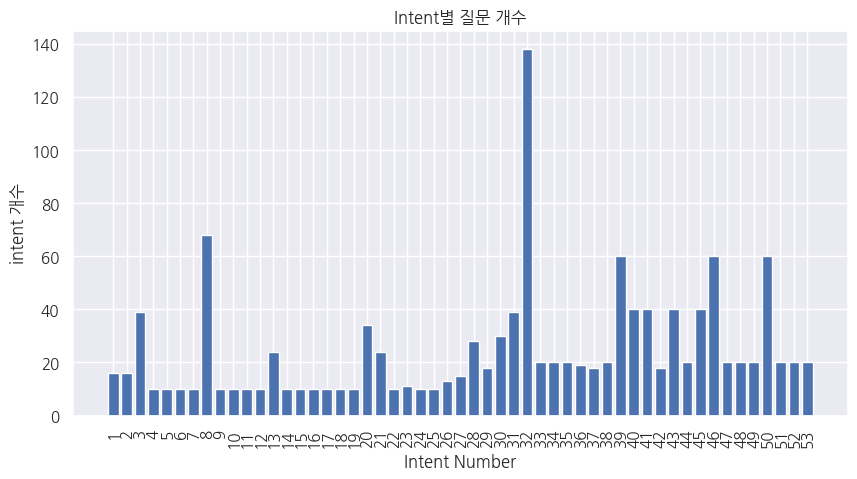

In [35]:
# 그래프 그리기
plt.figure(figsize=(10, 5))

plt.bar(dataframe['intent_num'], dataframe['intent개수'], )

# x축 눈금 설정
plt.xticks(range(1, 54, 1), rotation=90)

plt.xlabel('Intent Number')
plt.ylabel('intent 개수')
plt.title('Intent별 질문 개수')

plt.show()

*  시각화를 해보니 클래스 불균형 생각이 들었었다.<br>
예를 들어 intent가 32인 경우 count가 약 140여개에 달하고 있었다.<br>
그 외 몇개의 intent가 count가 높은 편에 속하는 것을 파악할 수 있다.

* 그래서 클래스 불균형에 대처할 수 있는 생각이 아래와 같다.

* 방법 1)리샘플링(Resampling)을 통해 오버샘플링(Oversampling) 또는 언더샘플링(Undersampling)을 하거나

* 방법 2)모델 학습할 떄 소수 클래스에 대해서 가중치를 더 부여하는 식이다.

* 하지만 방법 1은 데이터 자체에 변화를 주기 떄문에 방법 2는 데이터는 그대로 놔두고 소수 클래스에 대해 가중치를 더 부여하기 떄문에<br> 개인적으로 방법 2를 선호합니다.

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

* 먼저 질문별 문장 길이가 어떻게 분포됐는지 확인해야 한다.

In [36]:
df['Q'].apply(len).value_counts() #  질문별 문장 길이가 어떻게 분포됐는지 확인한다.

16     82
10     64
11     63
12     58
8      56
22     56
19     56
9      53
21     53
7      52
15     52
18     51
17     47
6      47
13     46
14     43
20     41
26     30
24     28
25     27
23     25
27     24
29     24
28     22
30     19
5      19
33     16
32     16
34     15
4      14
35     10
38      9
36      9
31      9
3       9
44      8
41      7
48      6
43      6
39      4
45      3
37      3
62      2
49      2
54      1
60      1
47      1
51      1
40      1
52      1
114     1
94      1
127     1
55      1
46      1
42      1
Name: Q, dtype: int64

In [37]:
# 샘플 데이터 생성
data = {
    'sentence_length': [16, 10, 11, 12, 8, 22, 19, 9, 21, 7, 15, 18, 17, 6, 13, 14, 20, 26, 24, 25, 23, 27, 29, 28, 30, 5, 33, 32, 34, 4, 35, 38, 36, 31, 3, 44, 41, 48, 43, 39, 45, 37, 62, 49, 54, 60, 47, 51, 40, 52, 114, 94, 127, 55, 46, 42],
    'count': [82, 64, 63, 58, 56, 56, 56, 53, 53, 52, 52, 51, 47, 47, 46, 43, 41, 30, 28, 27, 25, 24, 24, 22, 19, 19, 16, 16, 15, 14, 10, 9, 9, 9, 9, 8, 7, 6, 6, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

dataframe = pd.DataFrame(data)

# 'sentence_length' 열을 기준으로 오름차순 정렬
dataframe = dataframe.sort_values(by='sentence_length')

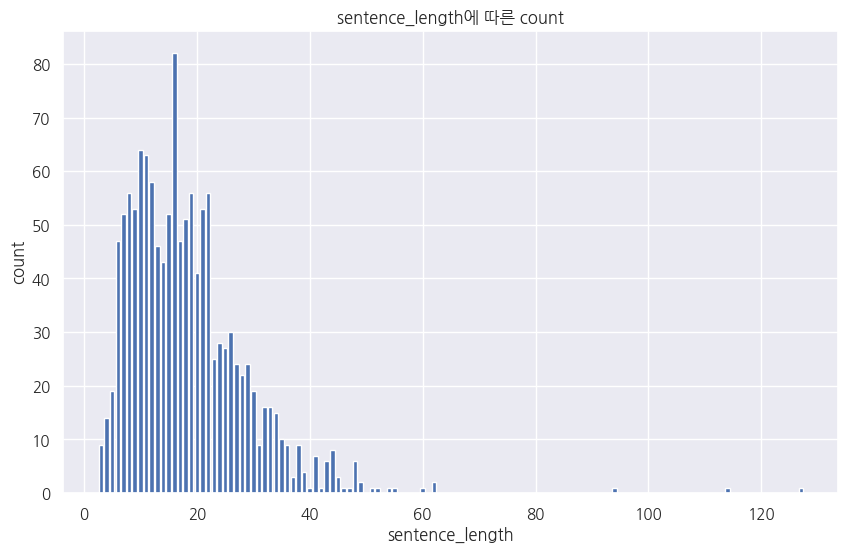

In [38]:
# 시각화
plt.figure(figsize=(10, 6))
plt.bar(dataframe['sentence_length'], dataframe['count'])
plt.xlabel('sentence_length')
plt.ylabel('count')
plt.title('sentence_length에 따른 count')
plt.show()

* 아! 그냥 그렇구나 하고 넘어갈려고 한다.
  * 자세한건 대화 유형(type)별 문장 길이 분포 비교에서 확인할 수 있도록!

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [39]:
df.head()

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0


In [40]:
# 'type' 변수가 0이냐(일상 대화) 1이냐(Q&A 대화)에 따라 문장별 길이 분포를 확인하고자 한다.
type_0 = df.loc[df['type'] == 0]
type_1 = df.loc[df['type'] == 1]

In [41]:
type_0['Q'].apply(len).value_counts()

10    55
9     52
11    52
7     52
8     51
6     46
12    38
13    32
14    25
16    20
5     19
4     14
15    11
3      9
17     5
19     5
20     5
21     4
18     4
22     3
24     2
23     1
28     1
Name: Q, dtype: int64

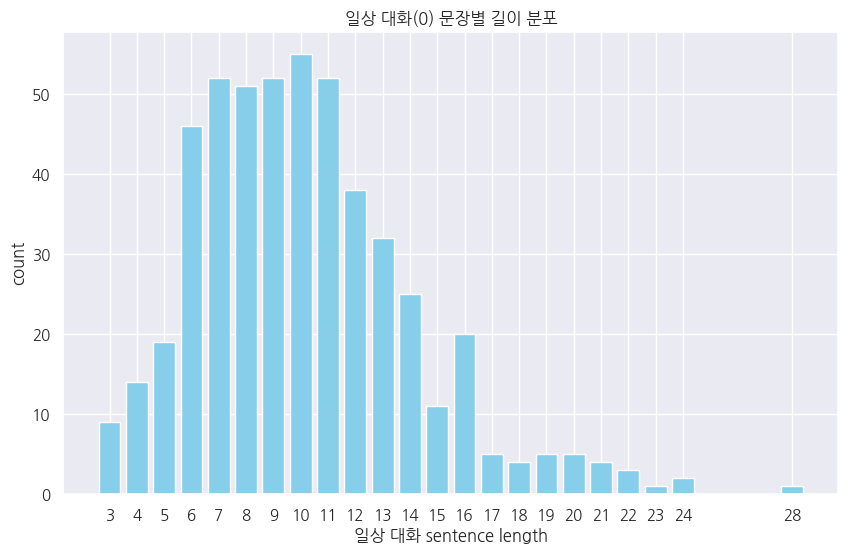

In [42]:
# 샘플 데이터 생성
data = {
    'sentence_length': [10, 9, 11, 7, 8, 6, 12, 13, 14, 16, 5, 4, 15, 3, 17, 19, 20, 21, 18, 22, 24, 23, 28],
    'count': [55, 52, 52, 52, 51, 46, 38, 32, 25, 20, 19, 14, 11, 9, 5, 5, 5, 4, 4, 3, 2, 1, 1]
}

dataframe = pd.DataFrame(data)

# 데이터 정렬
dataframe = dataframe.sort_values(by='sentence_length')

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.bar(dataframe['sentence_length'], dataframe['count'], color='skyblue')
plt.xlabel('일상 대화 sentence length')
plt.ylabel('count')
plt.title('일상 대화(0) 문장별 길이 분포')
plt.xticks(dataframe['sentence_length'])  # X축 눈금 설정
plt.show()

* sentence_length가 28이 거슬리긴 하는데
그냥 이정도면 이상치는 없다고 판단해도 될 것 같다.

In [43]:
type_1['Q'].apply(len).value_counts()

16     62
22     53
19     51
21     49
18     47
17     42
15     41
20     36
26     30
25     27
24     26
29     24
27     24
23     24
28     21
12     20
30     19
14     18
33     16
32     16
34     15
13     14
11     11
35     10
10      9
31      9
38      9
36      9
44      8
41      7
48      6
43      6
8       5
39      4
45      3
37      3
62      2
49      2
94      1
46      1
9       1
6       1
55      1
127     1
60      1
114     1
42      1
40      1
51      1
52      1
47      1
54      1
Name: Q, dtype: int64

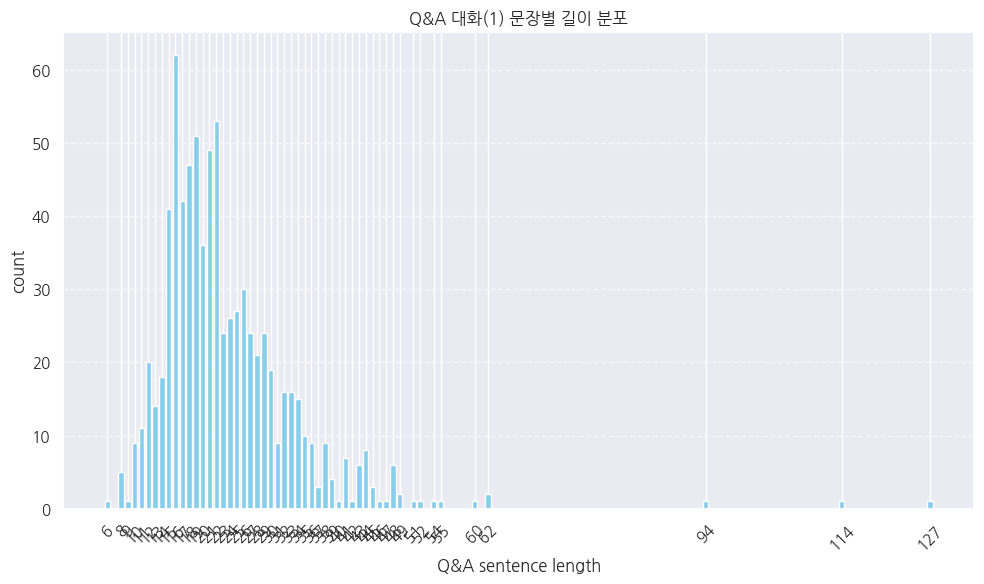

In [44]:
# 데이터 생성
data = {
    'sentence_length': [16, 22, 19, 21, 18, 17, 15, 20, 26, 25, 24, 29, 27, 23, 28, 12, 30, 14, 33, 32, 34, 13, 11, 35, 10, 31, 38, 36, 44, 41, 48, 43, 8, 39, 45, 37, 62, 49, 94, 46, 9, 6, 55, 127, 60, 114, 42, 40, 51, 52, 47, 54],
    'count': [62, 53, 51, 49, 47, 42, 41, 36, 30, 27, 26, 24, 24, 24, 21, 20, 19, 18, 16, 16, 15, 14, 11, 10, 9, 9, 9, 9, 8, 7, 6, 6, 5, 4, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

dataframe = pd.DataFrame(data)

# 데이터 정렬
dataframe = dataframe.sort_values(by='sentence_length')

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.bar(dataframe['sentence_length'], dataframe['count'], color='skyblue')
plt.xlabel('Q&A sentence length')
plt.ylabel('count')
plt.title('Q&A 대화(1) 문장별 길이 분포')
plt.xticks(dataframe['sentence_length'], rotation=45)  # X축 눈금 설정
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* sentence_length가 94, 114, 127인 부분이 거슬리는데
이것을 이상치라고 판단한다면,<br> sentence_length가 94, 114, 127인 것을 그냥 제거하거나 60자 정도로 줄여보는 것도 나쁘지 않은 것 같다.

* 그래서 데이터 탐색하면서 시각화 하는 부분에 대해서 질문이 있었습니다.

* 하면서 이해 안된거 정리.ipynb 파일로 이동...

## 2. 데이터 탐색까지 진행하면서 들었던 생각

* 일단 저는 그냥 intent가 클래스 불균형임에도 대처는 하지 않았고
* sentence_length가 이상치 인 부분이 몇개 보이지만 대처는 하지 않고
그냥 진행하려 합니다.

* 그래서 다해보고, 진짜 성능이 안좋거나 제 기준에서 만족하지 않았을 떄<br> 위에 대한 부분들을 처리하여 다시 모델을 만드려고 합니다.

## 3.데이터 전처리

* 세부요구사항
    * 다음 항목에 해당되는 전처리 함수를 각각 생성하여 하나로 합쳐봅시다.
        * 특수문자 제거 : 정규 표현식을 활용합니다. (띄어쓰기, \n 등)
        * 형태소 분석기 사용 : konlpy(mecab, kkma, Okt, etc), soynlp, khaiii 등 여러 형태소 분석기를 활용합니다.
    * 문장길이를 조절하여 모델 input으로 활용하기
    * joblib.dump를 이용하여 전처리 결과 데이터를 저장합니다.

### (1) 학습/평가 데이터 분리
   * test 데이터 : intent마다 무작위로 질문 2개를 뽑아 test 데이터로 분리
   * train 데이터 : 나머지 데이터


In [45]:
df.head()

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0


* chat gpt 행님의 도움을 받았습니다.

In [46]:
# 테스트 데이터를 저장할 빈 데이터프레임 생성
test_df = pd.DataFrame(columns=df.columns)

# 각 intent 그룹별로 무작위로 2개의 행을 선택하여 테스트 데이터로 추가
for intent in df['intent'].unique():
    intent_group = df.loc[df['intent'] == intent, :]
    test_samples = intent_group.sample(2, random_state=1)  # 랜덤 스테이트 설정으로 일관된 결과 얻기
    test_df = pd.concat([test_df, test_samples])

# 테스트 데이터에 속하는 행을 원본 데이터프레임에서 제거하여 트레이닝 데이터 생성
train_df = df.drop(test_df.index)

In [47]:
train_df.shape

(1192, 4)

In [48]:
test_df.shape

(106, 4)

* train_df의 인덱스 번호를 0부터 연속적인 정수로 부여한다.

In [49]:
train_df.reset_index(drop=True, inplace=True)

In [50]:
train_df

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0
4,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0
5,1,노트북을 떨어뜨려서 고장 난 것 같아.,AS센터에 맡겨보세요.,0
6,1,컴퓨터가 제대로 작동하지 않아요,AS센터에 맡겨보세요.,0
7,1,컴퓨터가 에러 메시지를 띄우고 있어요.,AS센터에 맡겨보세요.,0
8,1,컴터 고장났나봐,AS센터에 맡겨보세요.,0
9,1,컴터가 맛이 갔어,AS센터에 맡겨보세요.,0


* test_df의 인덱스 번호를 0부터 연속적인 정수로 부여한다.

In [51]:
test_df.reset_index(drop=True, inplace=True)

### (1.5) 데이터 전처리하기

* 0. 전반적으로 질문(Q)에 대해서 맟춤법을 정리한다.

  * Hanspell를 사용했다.

* 하지만  Hanspell이 많이 사용되지만, 서버 상태에 따라서는 사용이 제한될 수 있다고 chat gpt가 말해줬다.
* 나 역시 사용하려고 시도했지만, KeyError가 나서 사용하지 못하여 다른 방법을 이용하기로 했지만 결국 실패했다.<br> 그래서 맞춤법은 적용하지 못했다.

* 1. 특수문자를 제거한다.

In [52]:
import re
import string
#removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, -,∼,=,ㆍ<,>, .,?, !,【,】, …, ◆,%"
removal_list =  "‘’◇‘”’'·\“·△●■()\">>`/-∼=ㆍ<>.?!【】…◆%"
removal_list += string.punctuation
def cleansing_special(sentence: str = None) -> str:
    """
    특수문자를 전처리를 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)

    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    return sentence

In [53]:
train_df['Q'] = train_df['Q'].apply(cleansing_special)
test_df['Q'] = test_df['Q'].apply(cleansing_special)

* 2. 한국어 불용어 사전을 만들어서 불용어를 제거한다.
  * 구글에 떠도는 한국어 불용어 사전을 모아서 하십쇼! 경로도 자신의 상황에 맞게 해주시고!
  * 이거 꼭 안해셔도 됩니다. 안하실거면 주석 처리 하십쇼!

In [54]:
# 한글 불용어 사전을 만들어요...
korean_stopwords = []
for fileName in ['koreanStopwords.txt', 'stopwords.txt', 'stopword2.txt', 'stopword3.txt', 'stopword4.txt']:
    f = open(f'/content/drive/MyDrive/미니프로젝트6차part1/데이터/한국어불용어사전/{fileName}', 'r')
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n', '')
        line = line.replace('\t', '')
        korean_stopwords.append(line)
    f.close()
korean_stopwords = list(set(korean_stopwords))

In [55]:
!python3 -m pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 40.7 MB/s eta 0:00:00


In [56]:
from konlpy.tag import Okt

okt = Okt()

def remove_korean_stopwords(text): # 불용어 제거 함수
    morphs = okt.morphs(text)  # 텍스트를 형태소 단위로 분리
    filtered_words = [morph for morph in morphs if morph not in korean_stopwords]  # 한글 불용어 제거
    return ' '.join(filtered_words)

In [57]:
# 불용어 제거 적용
train_df['Q'] = train_df['Q'].apply(remove_korean_stopwords)
test_df['Q'] = test_df['Q'].apply(remove_korean_stopwords)

### (2) 형태소 분석하기
- konlpy, mecab 설치 후 형태소 분석 함수 생성
    * Colab에서는 아래 두 코드셀을 순차적으로 실행하면 설치 됩니다.
        * 참조 : https://konlpy.org/en/latest/install/
- 형태소 분석 결과를 다음의 이름으로 생성하시오.
    - clean_train_questions
    - clean_test_questions

* 표제어 추출(Lemmitaization)은 영어와 달리 한글 텍스트에는 별로 안쓰인다고 해서 패스(pass) 한다.

#### 1) 형태소 분석 패키지 설치

In [58]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
B

In [59]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   458k      0  0:00:03  0:00:03 --:--:--  806k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/config.guess
mecab-0.996-ko-0.9.2/README
mecab-0.996-ko-0.9.2/COPYING
mecab-0.996-ko-0.9.2/CHANGES.md
mecab-0.996-ko-0.9.2/README.md
mecab-0.996-ko-0.9.2/INSTALL
mecab-0

#### 2) 형태소 분석을 위한 함수를 제공합니다.

In [60]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [61]:
# 형태소 분석을 수행하는 함수
def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

#### 3) 형태소 분석 테스트
* 몇개 데이터에 대해 형태소 분석 확인하기

In [62]:
sentences = [
    '오늘 날씨가 정말 좋네요! 함께 산책이나 갈까요?',
    '어제 늦게까지 일하느라 정말 피곤했어요.',
    '이 책을 읽으면서 많은 것을 배울 수 있었어요.',
    '커피 한 잔의 여유를 즐기며 오늘의 일정을 계획해보세요.'
    '우리 나라의 전통문화를 소중히 지켜나가야 한다고 생각해요.',
    '안녕하세요 저는 릴러말즈 김민겸 입니다. 95년생이고 힙합을 아주 잘해요.'
]

In [63]:
for sentence in sentences:
    result = tokenize(tokenizer_name='okt', original_sent=sentence, nouns=False)
    print(result)

오늘 날씨 가 정말 좋네요 ! 함께 산책 이나 갈까 요 ?
어제 늦게까지 일 하느라 정말 피곤했어요 .
이 책 을 읽으면서 많은 것 을 배울 수 있었어요 .
커피 한 잔 의 여유 를 즐기며 오늘 의 일정 을 계획 해보세요 . 우리 나라 의 전통문화 를 소중히 지켜 나가야 한다고 생각 해요 .
안녕하세요 저 는 릴러말즈 김민겸 입니다 . 95년 생이고 힙합 을 아주 잘 해요 .


#### 4) train, test의 Q에 대해 형태소 분석하여 저장하기
* 데이터프레임의 각 행 별로 함수를 적용하는 방법
    * .apply(lambda ..........) 를 활용하면 손쉽게 처리할수 있습니다.

In [64]:
clean_train_questions = train_df['Q'].apply(lambda q : tokenize(tokenizer_name='okt', original_sent=q, nouns=False)) # Series로 저장
clean_test_questions = test_df['Q'].apply(lambda q : tokenize(tokenizer_name='okt', original_sent=q, nouns=False)) # Series로 저장

In [65]:
clean_train_questions

0                                                                                                                  떨어뜨려서 핸드폰 액정 나갔어
1                                                                                                                            액정 나갔어
2                                                                                                                   핸드폰 떨어뜨려서 고장 났나
3                                                                                                                      노트북 키 보드 먹히네
4                                                                                                                        노트북 전원 들어와
5                                                                                                                 노트북 떨어뜨려서 고장 난 같아
6                                                                                                                 컴퓨터 제대로 작동 하지 않아요
7                                                                           

In [66]:
clean_test_questions

0                                    노트북 작동 안되네
1                                      핸드폰 맛 갔어
2                                    건강 최고 인 같아
3                            올해 도 건강하고 행복하게 살거야
4                                        열나고 아파
5                                        추워 죽겠다
6                                       나들이 가볼까
7                                      놀러 가고 싶다
8                                     졸린데 못 자겠어
9                                       피곤 한테 잠
10                              고 3 은 공부 만 해야겠지
11                              새로운 공부 시작 해도 될까
12                                     나를 친구 했나
13                                        친구 인데
14                                       직장 괴롭다
15                                     다이어트 해야지
16                                넘어져서 발목 삔 거 애
17                                       독감 걸렸나
18                                         새 샀어
19                                         매매 샀
20                                      

### (3) 전처리 완료된 데이터를 파일로 저장하기
- 총 4개의 파일을 저장합니다.
    * train 셋
    * test 셋
    * 전처리된 데이터
        * clean_train_questions
        * clean_test_questions
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [63]:
# joblib.dump(df, '/content/drive/MyDrive/미니프로젝트6차part1/데이터/df.joblib')

In [64]:
# 데이터를 파일에 저장합니다.
# joblib.dump(train_df, '/content/drive/MyDrive/미니프로젝트6차part1/데이터/train_df.joblib')
# joblib.dump(test_df, '/content/drive/MyDrive/미니프로젝트6차part1/데이터/test_df.joblib')

In [65]:
# joblib.dump(clean_train_questions, '/content/drive/MyDrive/미니프로젝트6차part1/데이터/clean_train_questions.joblib')
# joblib.dump(clean_test_questions, '/content/drive/MyDrive/미니프로젝트6차part1/데이터/clean_test_questions.joblib')